# Social Media Sentiment Analysis - Mohamed Lasheen

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%matplotlib inline

In [ ]:
df = pd.read_csv("/content/sample_data/Tweets.csv")

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
df.isnull().sum().sort_values(ascending=False)

negativereason_gold             14608
airline_sentiment_gold          14600
tweet_coord                     13621
negativereason                   5462
user_timezone                    4820
tweet_location                   4733
negativereason_confidence        4118
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
airline                             0
name                                0
retweet_count                       0
text                                0
tweet_created                       0
dtype: int64

In [ ]:
print(f'Nulls Percentage:\n{(df.isnull().sum().sort_values(ascending=False) / len(df) * 100)}')

Nulls Percentage:
negativereason_gold             99.781421
airline_sentiment_gold          99.726776
tweet_coord                     93.039617
negativereason                  37.308743
user_timezone                   32.923497
tweet_location                  32.329235
negativereason_confidence       28.128415
tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
airline                          0.000000
name                             0.000000
retweet_count                    0.000000
text                             0.000000
tweet_created                    0.000000
dtype: float64


In [ ]:
df.drop(['negativereason_gold', 'airline_sentiment_gold', 'tweet_coord'], axis=1, inplace=True)

In [ ]:
df['tweet_created'] = pd.to_datetime(df['tweet_created']).dt.date

In [ ]:
df['tweet_created'].max() - df['tweet_created'].min()

datetime.timedelta(days=8)

In [ ]:
df.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
name                             7701
retweet_count                      18
text                            14427
tweet_created                       9
tweet_location                   3081
user_timezone                      85
dtype: int64

In [ ]:
print(f"Unique values in airline sentiment: {list(df['airline_sentiment'].unique())}")
print(f"Unique values in negative reason: {list(df['negativereason'].unique())}")

Unique values in airline sentiment: ['neutral', 'positive', 'negative']
Unique values in negative reason: [nan, 'Bad Flight', "Can't Tell", 'Late Flight', 'Customer Service Issue', 'Flight Booking Problems', 'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight', 'Damaged Luggage', 'longlines']


In [ ]:
df[['temp', 'text']] = df['text'].str.split(" ", 1, expand=True)
df.drop('temp', axis=1, inplace=True)
print(df['text'])

0                                     What @dhepburn said.
1        plus you've added commercials to the experienc...
2        I didn't today... Must mean I need to take ano...
3        it's really aggressive to blast obnoxious "ent...
4                 and it's a really big bad thing about it
                               ...                        
14635    thank you we got on a different flight to Chic...
14636    leaving over 20 minutes Late Flight. No warnin...
14637      Please bring American Airlines to #BlackBerry10
14638    you have my money, you change my flight, and d...
14639    we have 8 ppl so we need 2 know how many seats...
Name: text, Length: 14640, dtype: object


<ipython-input-100-0dd4606757c1>:1: FutureWarning:

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.



In [ ]:
def generate_word_cloud(sentiment_type):
  comment_words = ''
  stopwords = set(STOPWORDS)
  df['text'] = df['text'].str.lower()
  words = " ".join(cat for cat in df[df['airline_sentiment'] == sentiment_type]['text'])
  wordcloud = WordCloud(collocations=False, width = 1000, height = 1000,
                        background_color ='white', stopwords = stopwords, min_font_size = 10).generate(words)
  return wordcloud

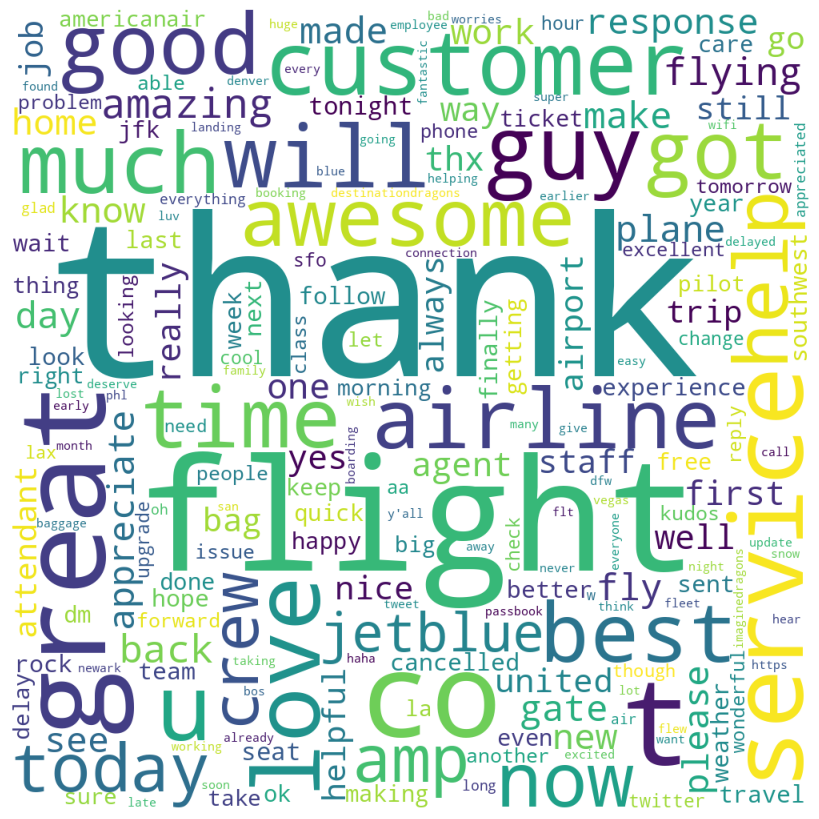

In [ ]:
res = generate_word_cloud('positive')
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(res)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

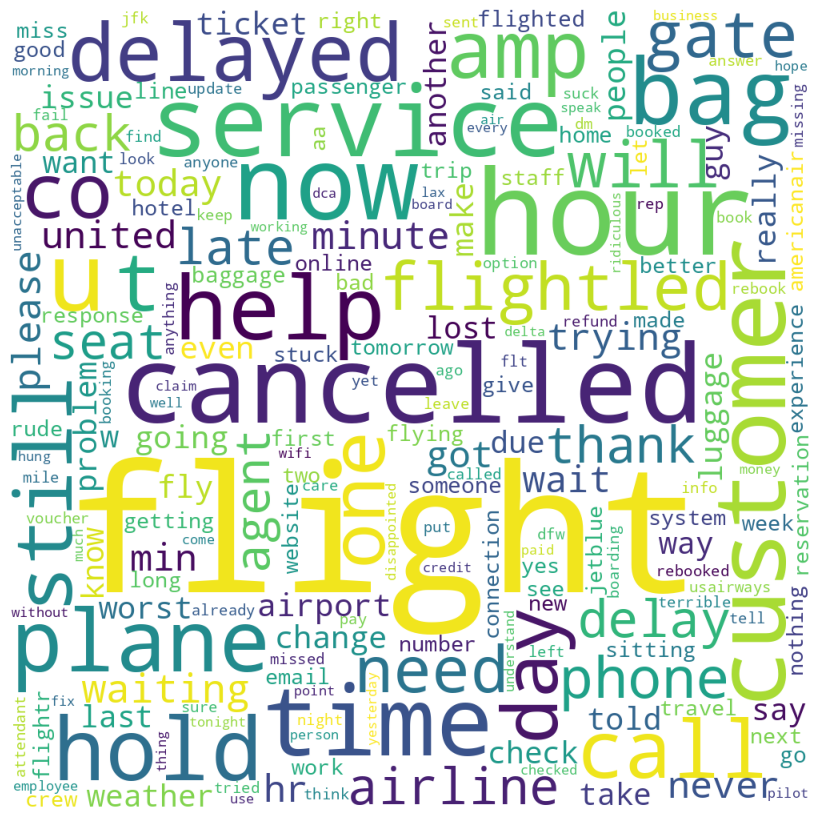

In [ ]:
res = generate_word_cloud('negative')
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(res)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

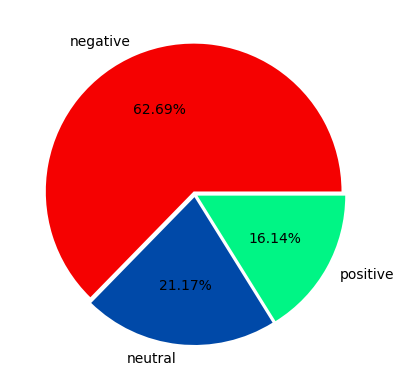

In [ ]:
sentiment = df['airline_sentiment'].value_counts()
palette_color = sns.color_palette('bright')
ax = plt.pie(sentiment, labels=sentiment.index, colors = ["#F50101", "#0049A8", "#00F585"], explode=[0.02, 0.02, 0.02], autopct='%.2f%%')

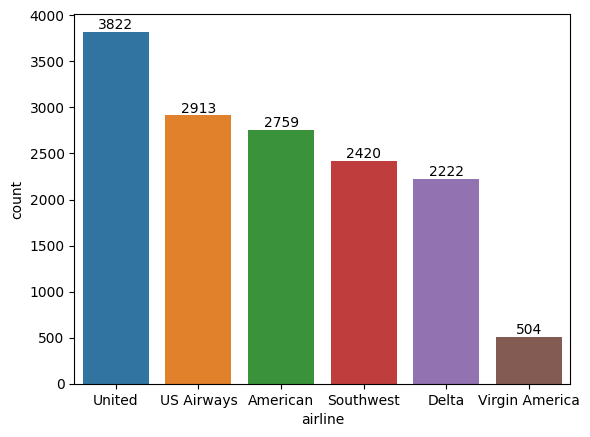

In [ ]:
ax = sns.countplot(df, x='airline', order=df['airline'].value_counts().index)
for bar in ax.containers:
  ax.bar_label(bar)

In [ ]:
df1 = df.groupby(['name', 'airline_sentiment']).size().unstack(fill_value=0)
sorted_indices = (df1["positive"] + df1["negative"] + df1['neutral']).sort_values(ascending=False).index
px.bar(df1.loc[sorted_indices[:10]], x=df1.loc[sorted_indices[:10]].index,
       y=['positive', 'negative', 'neutral'],
       barmode='group',
       color_discrete_map={'positive': '#00F585', 'negative': '#F50101',
                           'neutral': '#0049A8'},
       text_auto=True)

<ipython-input-107-be886bb3a31a>:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



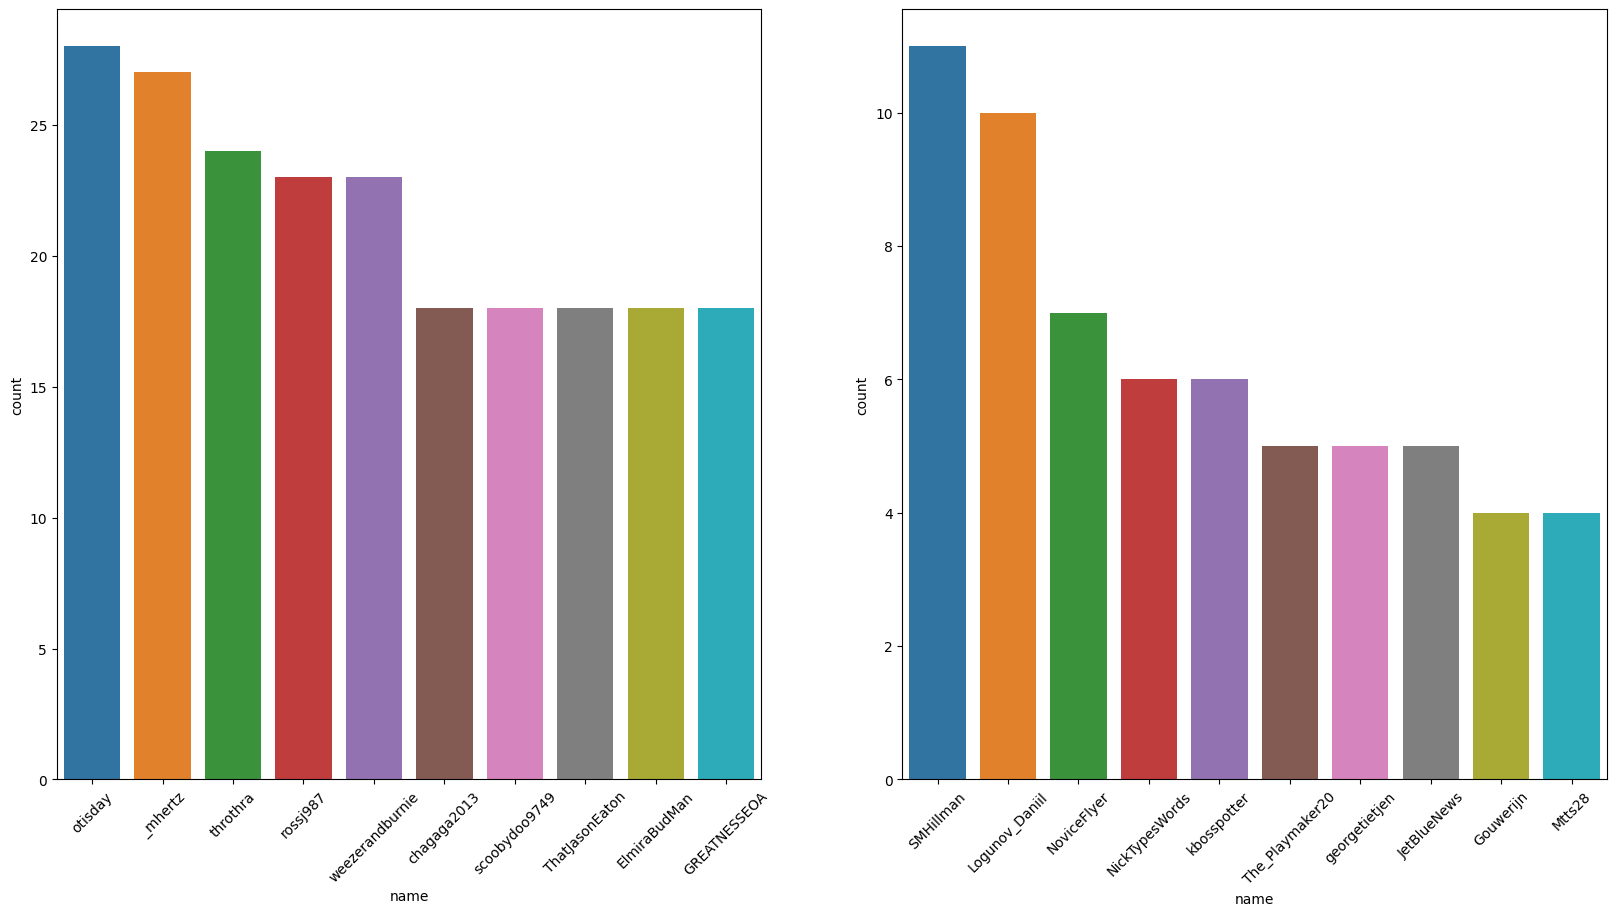

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.subplot(121)
neg = df[df['airline_sentiment'] == 'negative']
pos = df[df['airline_sentiment'] == 'positive']
ax = sns.countplot(neg, x='name', order=neg['name'].value_counts().sort_values(ascending=False).index[:10])
x = plt.xticks(rotation=45)
plt.subplot(122)
ax = sns.countplot(pos, x='name', order=pos['name'].value_counts().sort_values(ascending=False).index[:10])
x = plt.xticks(rotation=45)

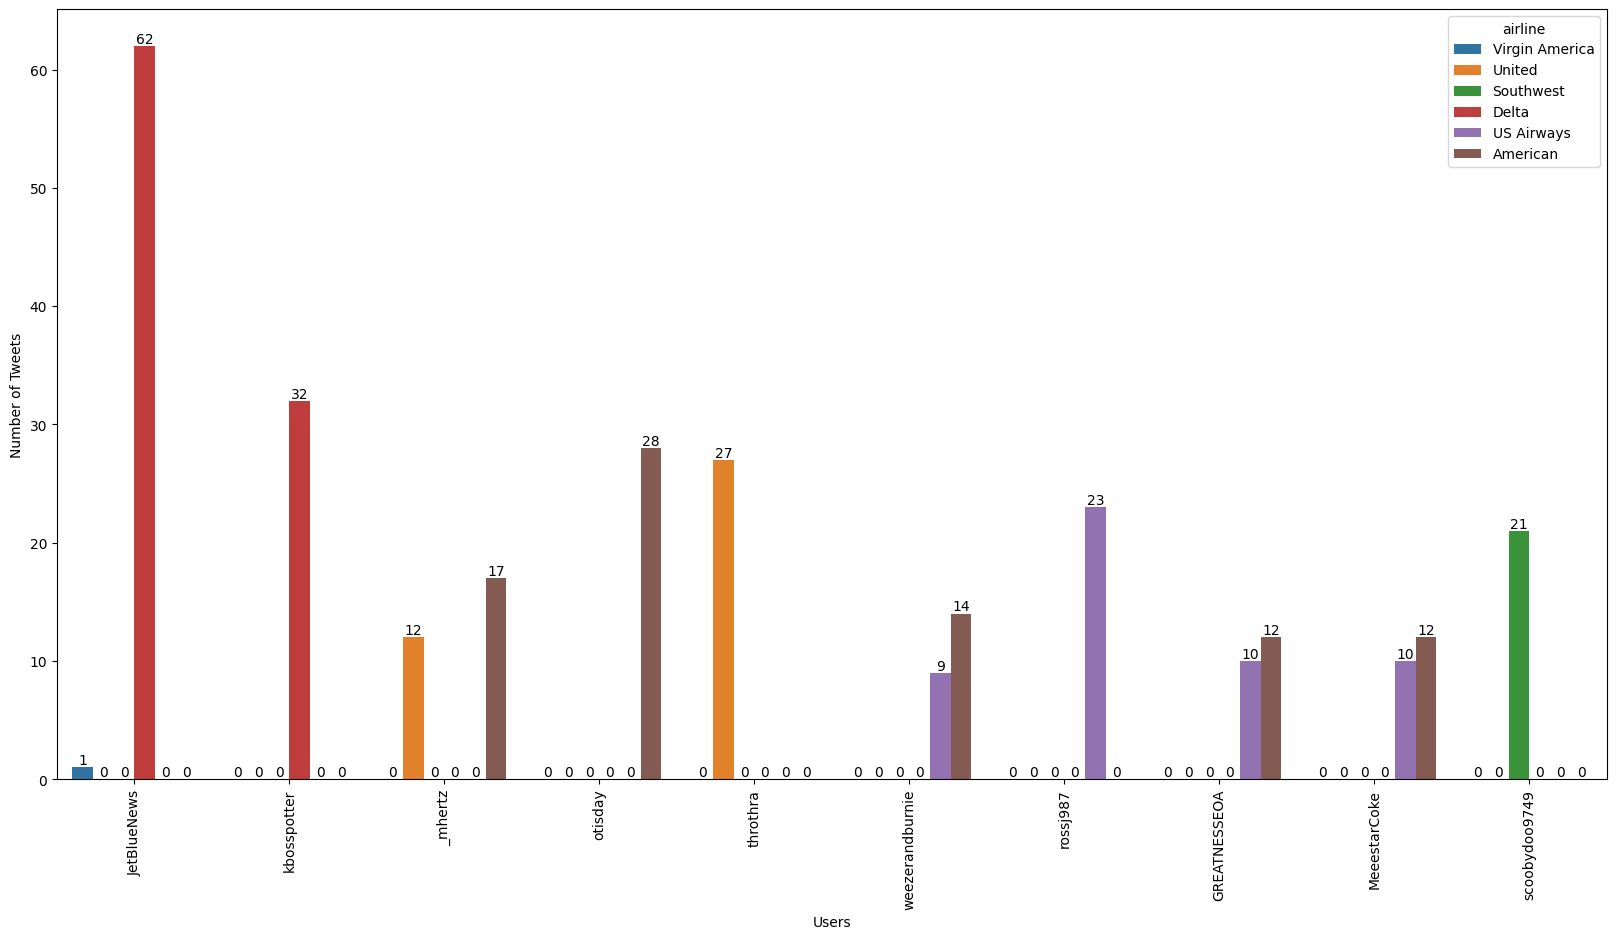

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(df, x='name', hue='airline', order=df['name'].value_counts().iloc[:10].index)
x = plt.xlabel("Users")
x = plt.ylabel("Number of Tweets")
x = plt.xticks(rotation=90)
for bar in ax.containers:
  ax.bar_label(bar)

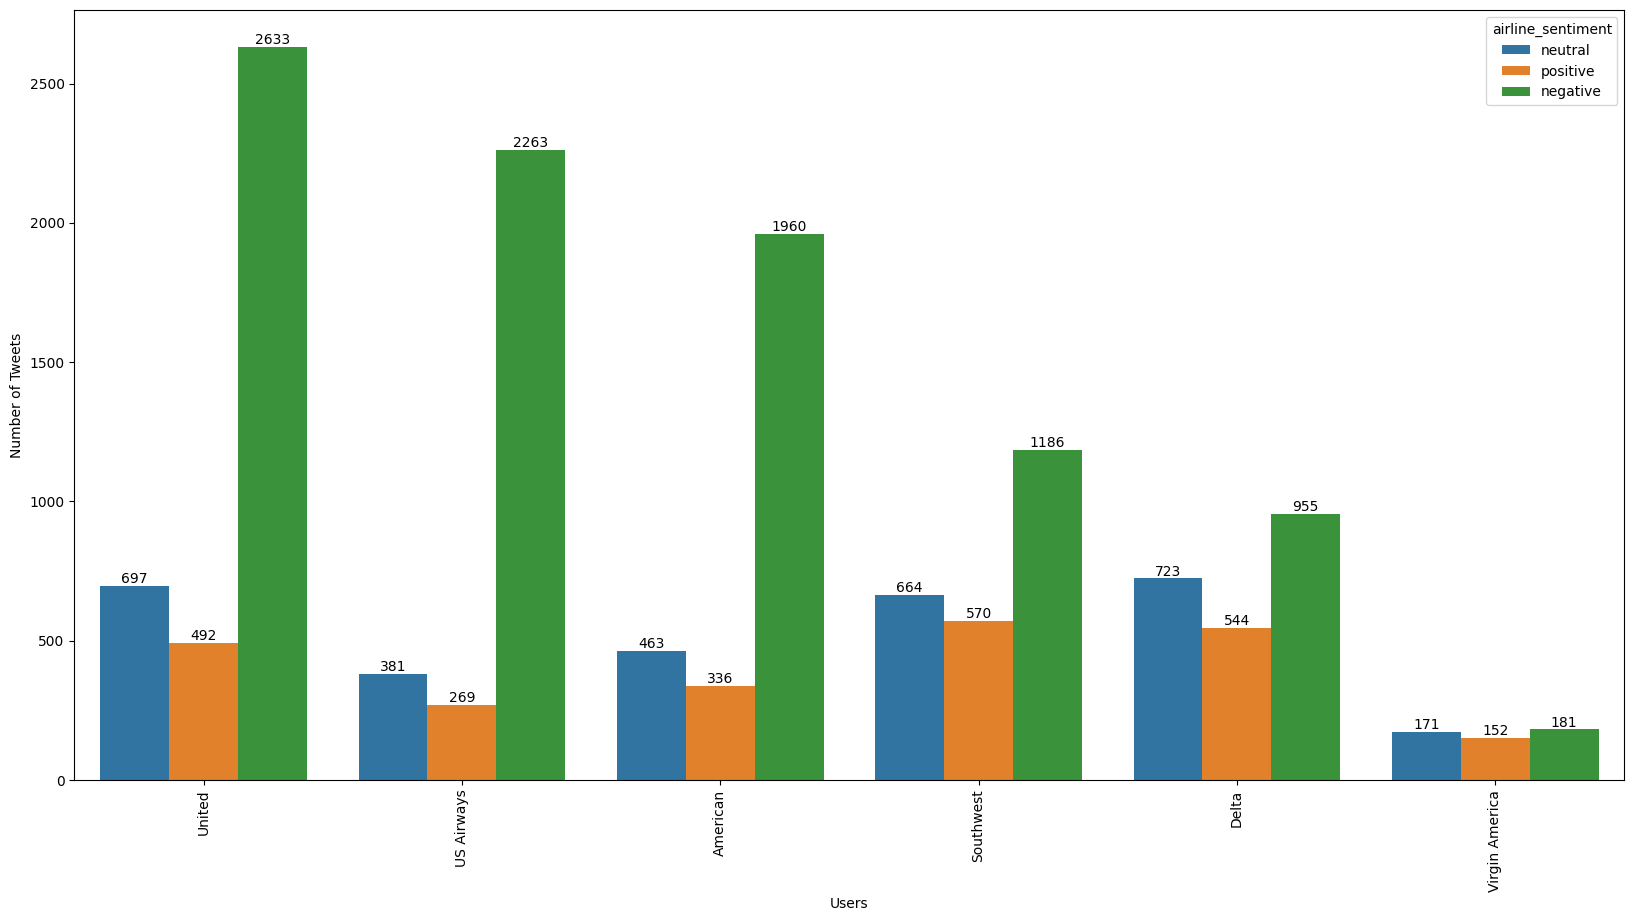

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(df, x='airline', hue='airline_sentiment', order=df['airline'].value_counts().iloc[:10].index)
x = plt.xlabel("Users")
x = plt.ylabel("Number of Tweets")
x = plt.xticks(rotation=90)
for bar in ax.containers:
  ax.bar_label(bar)

<ipython-input-110-baa31cabde24>:5: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



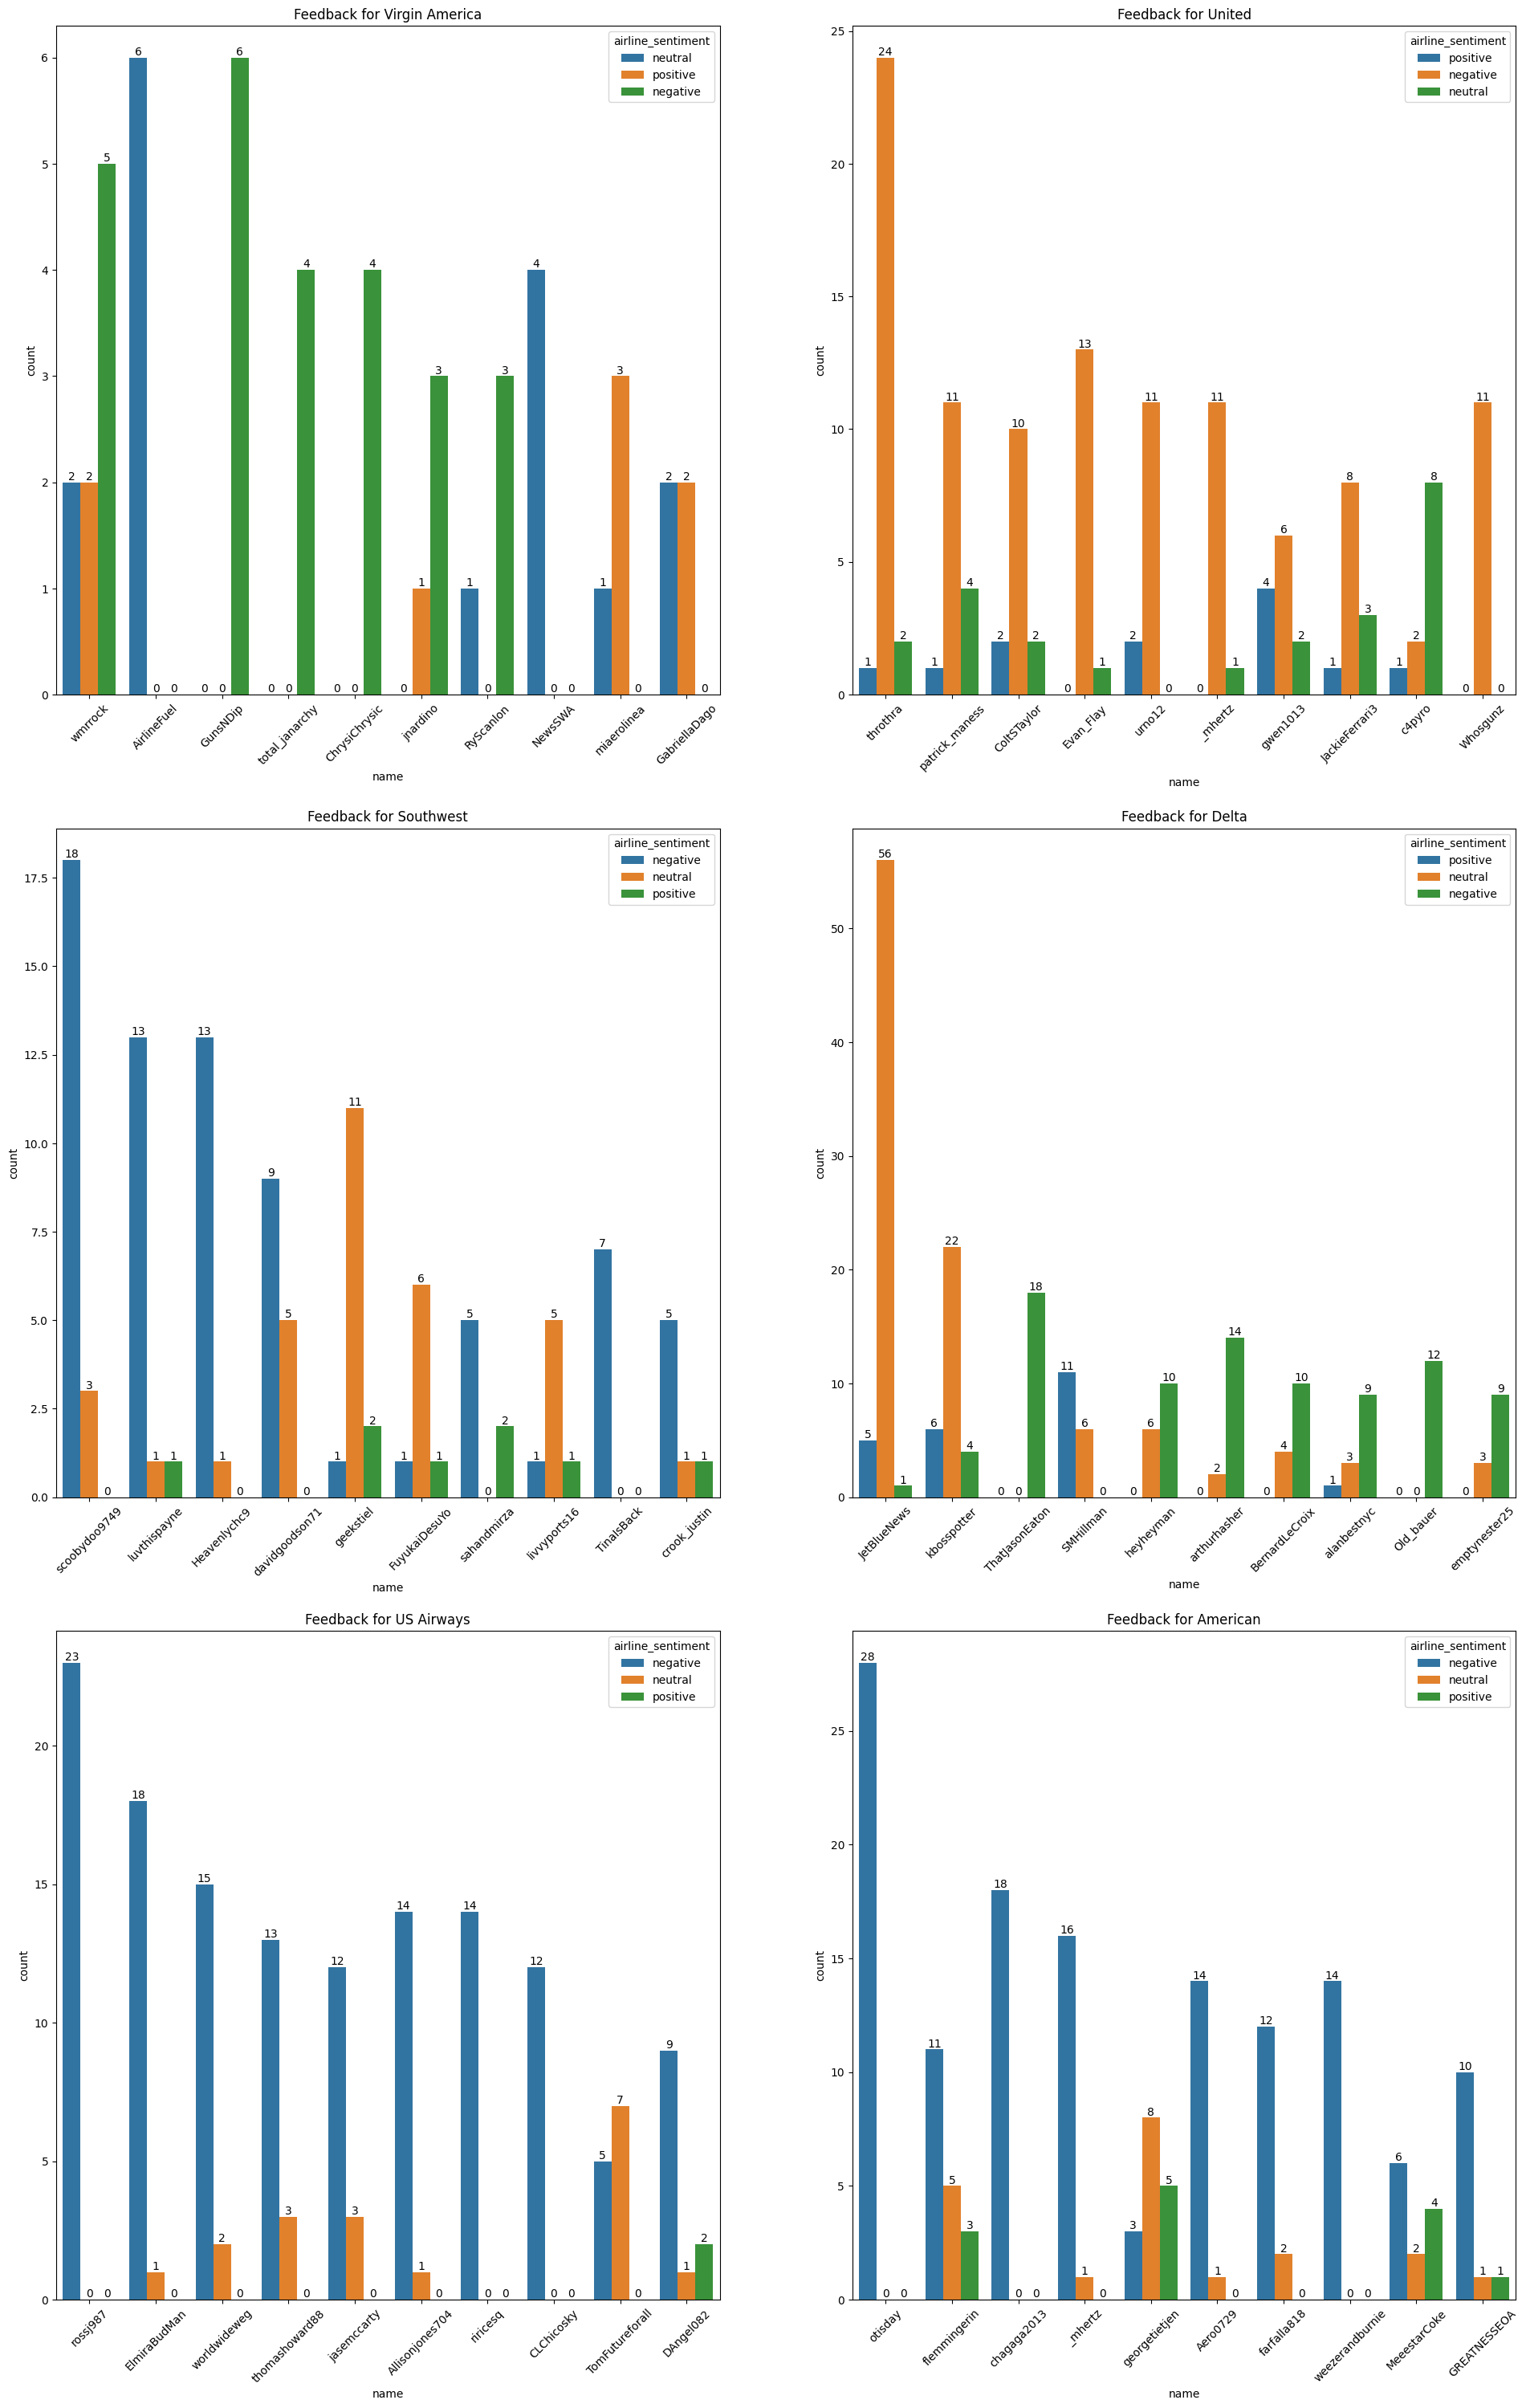

In [ ]:
fig, ax = plt.subplots(figsize=(20, 30))
fig.tight_layout(pad=5.0)
airline_list = list(df['airline'].unique())
for index, airline in enumerate(airline_list):
  plt.subplot(3, 2, index+1)
  ax = sns.countplot(data=df[df['airline']==airline], x='name', hue='airline_sentiment', order=df[df['airline']==airline]['name'].value_counts().iloc[:10].index)
  plt.title(f"Feedback for {airline}")
  plt.xticks(rotation=45)
  for bar in ax.containers:
    ax.bar_label(bar)

In [ ]:
df['negativereason'].fillna(df['negativereason'].mode(), inplace=True)

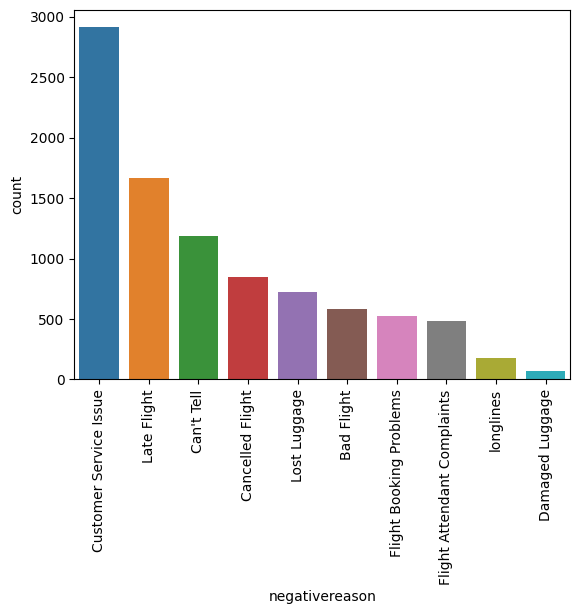

In [ ]:
sns.countplot(df, x='negativereason', order=df['negativereason'].value_counts().index)
plt.xticks(rotation=90)
for bar in ax.containers:
  ax.bar_label(bar)

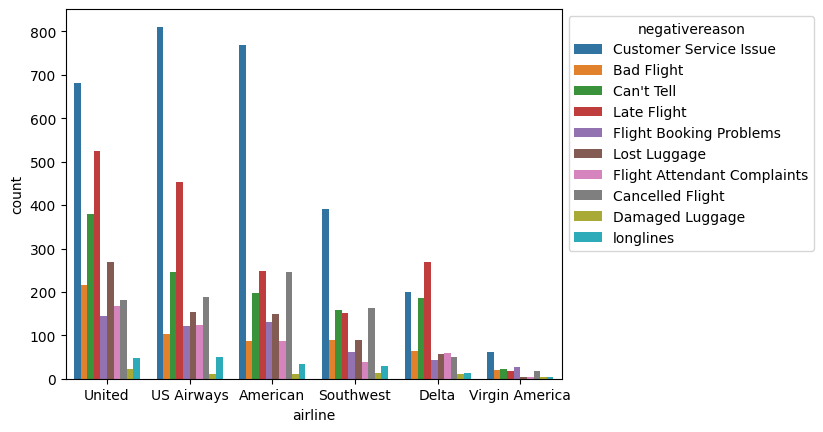

In [ ]:
ax = sns.countplot(df, x='airline', hue='negativereason', order=df['airline'].value_counts().index)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

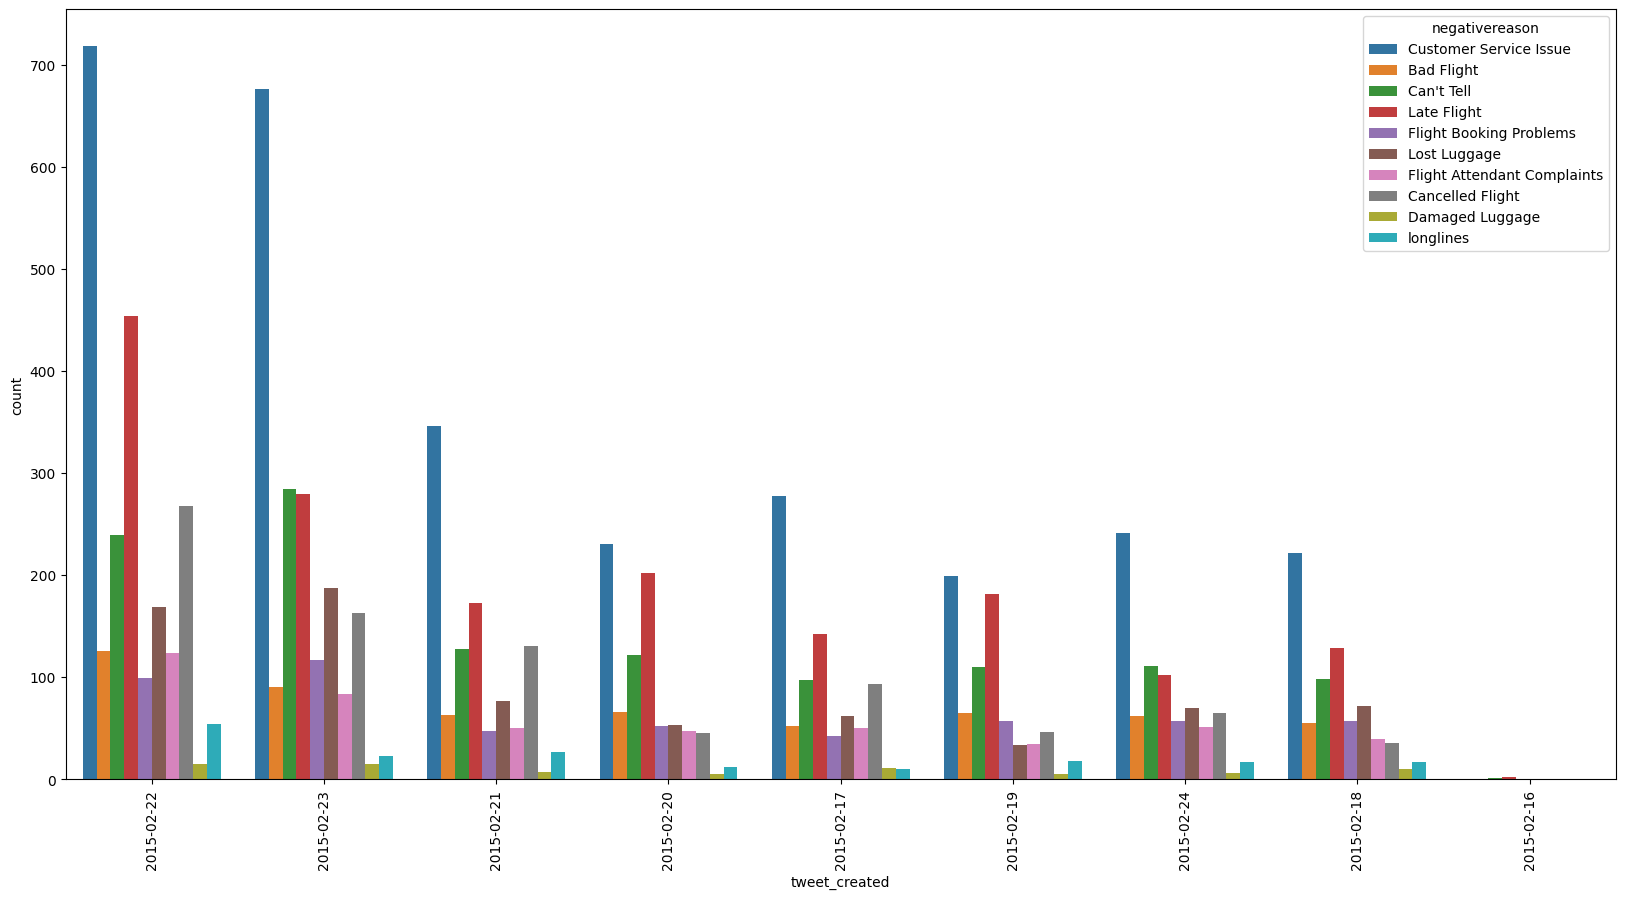

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.countplot(df, x='tweet_created', hue='negativereason', order=df['tweet_created'].value_counts().index)
x = plt.xticks(rotation=90)

In [ ]:
px.scatter_3d(df, x='tweet_created', y='negativereason', z='airline', color='airline', symbol='negativereason')

In [ ]:
px.histogram(df, x='tweet_created', color='negativereason', pattern_shape='airline', barmode='group')

In [ ]:
df.drop(df.loc[df['airline_sentiment']=='neutral'].index, inplace=True)

In [ ]:
label_encoder = LabelEncoder()
df['airline_sentiment'] = label_encoder.fit(df['airline_sentiment']).transform(df['airline_sentiment'])
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,jnardino,0,plus you've added commercials to the experienc...,2015-02-24,NaN,Pacific Time (US & Canada)
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,"it's really aggressive to blast obnoxious ""ent...",2015-02-24,NaN,Pacific Time (US & Canada)
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,and it's a really big bad thing about it,2015-02-24,NaN,Pacific Time (US & Canada)
5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,jnardino,0,seriously would pay $30 a flight for seats tha...,2015-02-24,NaN,Pacific Time (US & Canada)
6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,cjmcginnis,0,"yes, nearly every time i fly vx this “ear worm...",2015-02-24,San Francisco CA,Pacific Time (US & Canada)


In [ ]:
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ", tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join( meaningful_words ))

In [ ]:
nltk.download('stopwords')
df['clean_tweets']=df['text'].apply(lambda x: tweet_to_words(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
x = df['clean_tweets']
y = df['airline_sentiment']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [ ]:
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [ ]:
vect_tuning = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [ ]:
model = SVC(kernel='linear', random_state = 10)
model.fit(x_train_dtm, y_train)
pred = model.predict(x_test_dtm)

In [ ]:
accuracy_score(y_test,pred)

0.9029883066262451

In [ ]:
cm = confusion_matrix(y_test, pred)

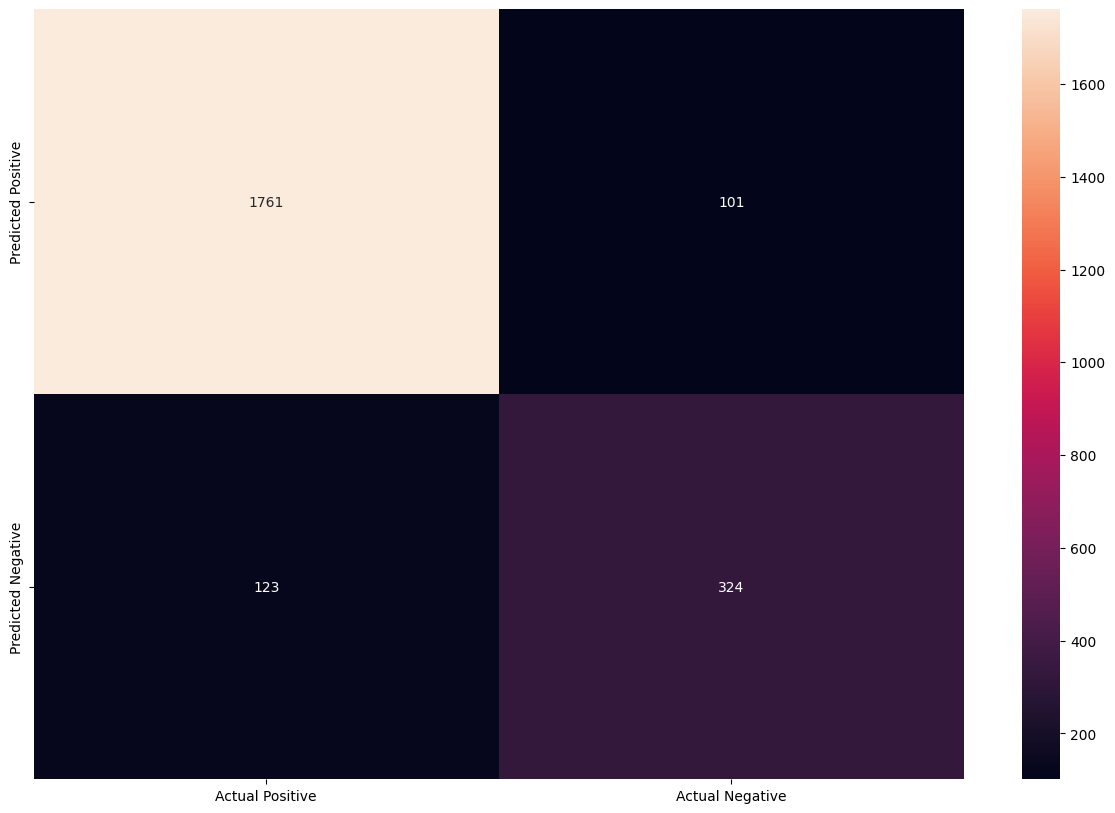

In [ ]:
_, ax= plt.subplots(figsize=(15, 10))
corr = pd.DataFrame(data = cm, columns = ['Actual Positive','Actual Negative'], index = ['Predicted Positive','Predicted Negative'])
ax = sns.heatmap(corr, annot = True, fmt = 'd')
plt.show()

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1862
           1       0.76      0.72      0.74       447

    accuracy                           0.90      2309
   macro avg       0.85      0.84      0.84      2309
weighted avg       0.90      0.90      0.90      2309

